##  Open Pulse Simulator - Rabi Example

If running the openpulse branch from source, may need to add a symbolic link in site-packages. Also run `python setup.py build_ext --inplace` in openpulse first.

In [1]:
#Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

#Import Qiskit classes classes
import qiskit
#from qiskit.providers.aer.noise import NoiseModel
#from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

import qiskit.pulse as pulse
import qiskit.pulse.pulse_lib as pulse_lib
from qiskit.compiler import assemble
import random
from qiskit.test.mock import FakeOpenPulse2Q

In [2]:
qiskit.IBMQ.load_account()

<AccountProvider for IBMQ(ibm-q, open, main)>

In [3]:
#Get a pulse configuration from the fake backend
backend_real = FakeOpenPulse2Q()
back_config = backend_real.configuration().to_dict()
system = pulse.PulseChannelSpec.from_backend(backend_real)

In [4]:
#Get pulse simulator backend
backend_sim = qiskit.Aer.get_backend('pulse_simulator')

## Simulations

### These need to be run in sequential order

[Rabi Oscillation](#rabi)
Apply a pulse to Q0 and measure the population evoluation versus pulse amplitude

[Measurement Level 1 for the Readout Test](#readout_test)
<br> Prepare the |0> and |1> states and look at the measurement level 1 output 

[CR Oscillation](#cr)
<br> Look at the Q1 State when we drive Q0 at the frequency of Q1

[T1](#t1)
<br>Demonstrating noise with pulse

<a id='rabi'></a>
# Simulate a Rabi Oscillation

First, we are going to simulate a rabi oscillation, i.e., meausure the qubit state population versus the amplitude of a drive pulse. This is the same example that is in the tutorials.

### Build Pulse Schedule 

Build on qubit 0

In [5]:
#qubit to use for exeperiment
qubit = 0
# exp configuration
exps = 41
shots = 512

# Rabi pulse
drive_amps = np.linspace(0, 0.9, exps)
drive_samples = 128
drive_sigma = 16

# Measurement pulse
meas_amp = 0.025
meas_samples = 1200
meas_sigma = 4
meas_risefall = 25

# Measurement pulse (common for all experiment)
meas_pulse = pulse_lib.gaussian_square(duration=meas_samples, amp=meas_amp,
                                       sigma=meas_sigma, risefall=meas_risefall, 
                                       name='meas_pulse')
acq_cmd=pulse.Acquire(duration=meas_samples)

# create measurement schedule
measure_and_acquire = meas_pulse(system.qubits[qubit].measure) | acq_cmd(system.acquires, system.memoryslots)

# Create schedule
schedules = []
for ii, drive_amp in enumerate(drive_amps):
    # drive pulse
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples, 
                                    amp=drive_amp, 
                                    sigma=drive_sigma, name='rabi_pulse_%d' % ii)
    
    # add commands to schedule
    schedule = pulse.Schedule(name='rabi_exp_amp_%s' % drive_amp)
    
    schedule += rabi_pulse(system.qubits[qubit].drive)
    schedule += measure_and_acquire << schedule.duration
 
    schedules.append(schedule)

### Design the Hamiltonian

Let's build a transmon Hamiltonian with anharmonicity to test the Rabi oscillation and CR

In [6]:
hamiltonian = {}
hamiltonian['h_str'] = []
#Q0 terms
hamiltonian['h_str'].append('np.pi*(2*v0-alpha0)*O0')
hamiltonian['h_str'].append('np.pi*alpha0*O0*O0')
hamiltonian['h_str'].append('2*np.pi*r*X0||D0')
hamiltonian['h_str'].append('2*np.pi*r*X0||U1')
hamiltonian['h_str'].append('2*np.pi*r*X1||U0')

#Q1 terms
hamiltonian['h_str'].append('np.pi*(2*v1-alpha1)*O1')
hamiltonian['h_str'].append('np.pi*alpha1*O1*O1')
hamiltonian['h_str'].append('2*np.pi*r*X0||D1')

#Exchange coupling betwene Q0 and Q1
hamiltonian['h_str'].append('2*np.pi*j*(Sp0*Sm1+Sm0*Sp1)')
hamiltonian['vars'] =  {'v0': 5.00, 'v1': 5.1, 'j': 0.01, 
                        'r': 0.02, 'alpha0': -0.33, 'alpha1': -0.33}

#set the qubit dimensions to 3
hamiltonian['qub'] = {'0': 3, '1': 3}

#update the back_end
back_config['hamiltonian'] = hamiltonian
back_config['noise'] = {}
back_config['dt'] = 1.0

### Add Solver Settings

Any solver settings also does into the back_config

In [7]:
back_config['ode_options'] = {}

### Restrict the Qubits Used in the Simulation 

We can use a qubit whitelist (`qubit_list`) to restrict the set of qubits used in the solution. The pulse simulator will appropriately alter the Hamiltonian. To start let's assume the list contains the first 2 qubits.

In [8]:
back_config['qubit_list'] = [0,1]
#back_config['qubit_list'] = None

### Assemble the qobj with the backend config file and the qubit_list

We have to do this step twice to get the dressed frequencies for setting the LO's. Note here that we set `meas_level=1` and `meas_return=avg` which will return the average probability for the qubit to be in the |1> state.

In [9]:
rabi_qobj = assemble(schedules, backend_real, 
                     meas_level=1, meas_return='avg', 
                     memory_slots=2,
                     shots=shots, sim_config = back_config)

In [10]:
evals = backend_sim.get_dressed_energies(rabi_qobj)

In [11]:
evals/2/np.pi

array([ 0.        ,  4.9990098 ,  9.66953431,  5.1009902 , 10.10132826,
       14.76614835,  9.86913744, 14.87385165, 19.54      ])

In [12]:
rabi_qobj = assemble(schedules, backend_real, 
                     meas_level=1, meas_return='avg', 
                     memory_slots=2, qubit_lo_freq = [evals[1]/2/np.pi,
                                                      evals[3]/2/np.pi],
                     shots=shots, sim_config = back_config)

### Simulate

In [13]:
#Note: this is how to run bypassing the backend
#opsys = qiskit.providers.aer.openpulse.qobj.digest.digest_pulse_obj(rabi_qobj.to_dict())
#simdata = qiskit.providers.aer.openpulse.solver.opsolve.opsolve(opsys)

In [14]:
sim_result = backend_sim.run(rabi_qobj).result()

Extract the qubit populations 

In [15]:
amp_data_Q0 = []
amp_data_Q1 = []

for exp_idx in range(len(drive_amps)):
    exp_mem = sim_result.get_memory(exp_idx)
    amp_data_Q0.append(np.abs(exp_mem[0]))
    amp_data_Q1.append(np.abs(exp_mem[1]))

Pi Amplitude 0.315141


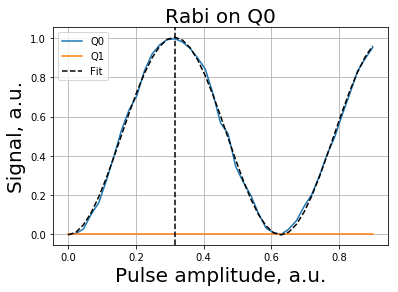

In [16]:
#Fit the data
fit_func = lambda x,A,B,T,phi: (A*np.cos(2*np.pi*x/T+phi)+B)
fitparams, conv = curve_fit(fit_func, drive_amps, amp_data_Q0, [0.5,0.5,0.6,1.5])

#get the pi amplitude
pi_amp = (fitparams[3])*fitparams[2]/2/np.pi

plt.plot(drive_amps, amp_data_Q0, label='Q0')
plt.plot(drive_amps, amp_data_Q1, label='Q1')
plt.plot(drive_amps, fit_func(drive_amps, *fitparams), color='black', linestyle='dashed', label='Fit')
plt.axvline(pi_amp, color='black', linestyle='dashed')
plt.legend()
plt.xlabel('Pulse amplitude, a.u.', fontsize=20)
plt.ylabel('Signal, a.u.', fontsize=20)
plt.title('Rabi on Q0', fontsize=20)
plt.grid(True)

print('Pi Amplitude %f'%(pi_amp))

<a id='readout_test'></a>
# Look at the Shots Distribution

Using the pulse amplitude calibrated above, do an experiment with no pulse and an experiment with a pi pulse and look at the measurement outcomes. 

In [17]:
# Create schedule
pi_pulse = pulse_lib.gaussian(duration=drive_samples,
                                amp=pi_amp, 
                                sigma=drive_sigma,
                                name='pi_pulse')

pi_2_pulse = pulse_lib.gaussian(duration=drive_samples,
                                amp=pi_amp/2, 
                                sigma=drive_sigma,
                                name='pi_2_pulse')
    
# excited
excited_exp = pulse.Schedule(name='pi_exp')
excited_exp += pi_pulse(system.qubits[qubit].drive)
measure_time = excited_exp.duration
excited_exp |= measure_and_acquire << measure_time

# superposition
sup_exp = pulse.Schedule(name='pi_2_exp')
sup_exp += pi_2_pulse(system.qubits[qubit].drive)
measure_time = sup_exp.duration
sup_exp |= measure_and_acquire << measure_time

# ground
ground_exp = pulse.Schedule(name='no_pi_exp')
ground_exp |= pulse.Schedule(name='ground_exp')
ground_exp |= measure_and_acquire << measure_time 

excited_exp_schedules = [ground_exp, sup_exp, excited_exp]

Change the `meas_return=single` which will return each individual measurement

In [18]:
readout_qobj = assemble(excited_exp_schedules, backend_real, 
                     meas_level=1, meas_return='single', 
                     memory_slots=2, qubit_lo_freq = [evals[1]/2/np.pi,
                                                      evals[3]/2/np.pi],
                     shots=shots, sim_config = back_config)

In [19]:
sim_result = backend_sim.run(readout_qobj).result()

Plot the data, there is no measurement error in the simulator data so the histographs will be all centered at the average point.

In [20]:
ground_data = sim_result.get_memory(0)[:, qubit]
excited_data = sim_result.get_memory(2)[:, qubit]
sup_data = sim_result.get_memory(1)[:, qubit]

Add some random noise to the data to better approximate the experiment

In [21]:
for idx in range(len(ground_data)):
    ground_data[idx] += random.gauss(0,0.1)+1j*random.gauss(0,0.1)
    excited_data[idx] += random.gauss(0,0.1)+1j*random.gauss(0,0.1)
    sup_data[idx] += random.gauss(0,0.1)+1j*random.gauss(0,0.1)

Text(0, 0.5, 'Q (a.u.)')

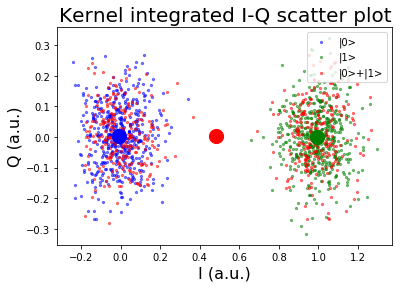

In [22]:

plt.scatter(np.real(ground_data), np.imag(ground_data), s=5, cmap='viridis',c='blue',alpha=0.5, label='|0>')
plt.scatter(np.real(excited_data), np.imag(excited_data), s=5, cmap='viridis',c='green',alpha=0.5, label='|1>')
plt.scatter(np.real(sup_data), np.imag(sup_data), s=5, cmap='viridis',c='red',alpha=0.5, label='|0>+|1>')
ground_center = np.mean(ground_data)
excited_center = np.mean(excited_data)
sup_center = np.mean(sup_data)

plt.scatter(np.real(ground_center), np.imag(ground_center), c='blue', s=200, alpha=1.0)
plt.scatter(np.real(excited_center), np.imag(excited_center), c='green', s=200, alpha=1.0)
plt.scatter(np.real(sup_center), np.imag(sup_center), c='red', s=200, alpha=1.0)

plt.title('Kernel integrated I-Q scatter plot', fontsize=20)
plt.legend(loc='upper right')
plt.xlabel('I (a.u.)', fontsize=16)
plt.ylabel('Q (a.u.)', fontsize=16)

<a id='cr'></a>
# Cross-Resonance

Simulate cross-resonance by driving on U0. Note you need to run Rabi first to setup the hamiltonian.

In [23]:
#qubit to use for exeperiment
qubit = 0
# exp configuration
exps = 41
shots = 512

# Rabi pulse
cr_drive_amps = np.linspace(0, 0.9, exps)
cr_drive_samples = 128*3
cr_drive_sigma = 4


# Create schedule
schedules = []
for ii, cr_drive_amp in enumerate(cr_drive_amps):
    # drive pulse
    cr_rabi_pulse = pulse_lib.gaussian_square(duration=cr_drive_samples, 
                                    amp=cr_drive_amp, 
                                    risefall=cr_drive_sigma*4,
                                    sigma=cr_drive_sigma, name='rabi_pulse_%d' % ii)
    
    # add commands to schedule
    schedule = pulse.Schedule(name='cr_rabi_exp_amp_%s' % cr_drive_amp)
    
    schedule += cr_rabi_pulse(system.controls[0])
    schedule += measure_and_acquire << schedule.duration
 
    schedules.append(schedule)

In [24]:
cr_rabi_qobj = assemble(schedules, backend_real, 
                     meas_level=1, meas_return='avg', 
                     memory_slots=2, qubit_lo_freq = [evals[1]/2/np.pi,
                                                      evals[3]/2/np.pi],
                     shots=shots, sim_config = back_config)

In [25]:
sim_result = backend_sim.run(cr_rabi_qobj).result()

In [26]:
amp_data_Q0 = []
amp_data_Q1 = []

for exp_idx in range(len(cr_drive_amps)):
    exp_mem = sim_result.get_memory(exp_idx)
    amp_data_Q0.append(np.abs(exp_mem[0]))
    amp_data_Q1.append(np.abs(exp_mem[1]))

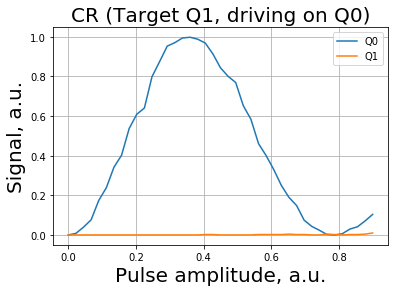

In [27]:
plt.plot(drive_amps, amp_data_Q0, label='Q0')
plt.plot(drive_amps, amp_data_Q1, label='Q1')
plt.legend()
plt.xlabel('Pulse amplitude, a.u.', fontsize=20)
plt.ylabel('Signal, a.u.', fontsize=20)
plt.title('CR (Target Q1, driving on Q0)', fontsize=20)
plt.grid(True)

<a id='t1'></a>
# T1

Using the calibrated Pi pulse add a T1 decay channel and simulate a t1 experiment. This can take a while to run. The noise operators in pulse are still a work in progress.

In [28]:

t1_times = np.linspace(0,500,10)
t1_times = np.array(t1_times, dtype=int)

T1_exps = []
for kk in range(len(t1_times)):
    schedule = pulse.Schedule(name='T1_{}'.format(kk))
    schedule |= pi_pulse(system.qubits[qubit].drive) << schedule.duration
    schedule |= measure_and_acquire << int(t1_times[kk]) + schedule.duration
    T1_exps.append(schedule)

In [29]:
# Add noise to the Hamiltonian on qubit '0'
back_config['noise'] = {"qubit": 
                        {"0": 
                         {"Sm": 0.006
                         }}}
#back_config['noise'] = {}

In [30]:
t1_qobj = assemble(T1_exps, backend_real, 
                     meas_level=1, meas_return='avg', 
                     memory_slots=2, qubit_lo_freq = [evals[1]/2/np.pi,
                                                      evals[3]/2/np.pi],
                     shots=100, sim_config = back_config)

In [31]:
sim_result_t1 = backend_sim.run(t1_qobj).result()

In [32]:
t1_data_Q0 = []
t1_data_Q1 = []


for exp_idx in range(len(t1_times)):
    exp_mem = sim_result_t1.get_memory(exp_idx)
    t1_data_Q0.append(np.abs(exp_mem[0]))
    t1_data_Q1.append(np.abs(exp_mem[1]))


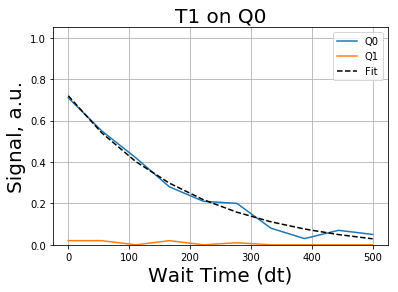

In [33]:
#Fit the data
fit_func_t1 = lambda x,A,B,T: (A*np.exp(-x/T)+B)
fitparams, conv = curve_fit(fit_func_t1, t1_times, t1_data_Q0, [0.5,0.5,100])


plt.plot(t1_times, t1_data_Q0, label='Q0')
plt.plot(t1_times, t1_data_Q1, label='Q1')
plt.plot(t1_times, fit_func_t1(t1_times, *fitparams), color='black', linestyle='dashed', label='Fit')

plt.legend()
plt.xlabel('Wait Time (dt)', fontsize=20)
plt.ylabel('Signal, a.u.', fontsize=20)
plt.ylim([0,1.05])
plt.title('T1 on Q0', fontsize=20)
plt.grid(True)
